# <Font color = 'pickle'>**Load Libraries/Install Software**


In [ ]:
if 'google.colab' in str(get_ipython()):
  print('Running on Colab')
else:
  print('Not running on Colab')

Running on Colab


In [ ]:
if 'google.colab' in str(get_ipython()):
  !pip install wandb --upgrade -q

     |████████████████████████████████| 1.9 MB 27.3 MB/s 
     |████████████████████████████████| 182 kB 17.7 MB/s 
     |████████████████████████████████| 166 kB 49.7 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
     |████████████████████████████████| 166 kB 49.4 MB/s 
     |████████████████████████████████| 162 kB 72.0 MB/s 
     |████████████████████████████████| 162 kB 72.4 MB/s 
     |████████████████████████████████| 158 kB 71.6 MB/s 
     |████████████████████████████████| 157 kB 72.9 MB/s 
     |████████████████████████████████| 157 kB 68.6 MB/s 
     |████████████████████████████████| 157 kB 70.8 MB/s 
     |████████████████████████████████| 157 kB 70.4 MB/s 
     |████████████████████████████████| 157 kB 72.4 MB/s 
     |████████████████████████████████| 157 kB 69.1 MB/s 
     |████████████████████████████████| 157 kB 75.2 MB/s 
     |████████████████████████████████| 156 kB 71.1 MB/s 


In [ ]:
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Importing the libraries

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F

from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR, CyclicLR, ExponentialLR

import numpy as np
import random

from datetime import datetime
from pathlib import Path
import sys
from types import SimpleNamespace

import wandb

In [ ]:
#Login into wandb

wandb.login()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
wandb.init(name = "Hw6_CIFAR10.ipynb", project = 'dl22_HW6')

wandb: Currently logged in as: pranavshekhar2. Use `wandb login --relogin` to force relogin


# <Font color = 'pickle'>**Specify Project Folders**

In [ ]:
# This is the path where we will download and save data
if 'google.colab' in str(get_ipython()):
  data_folder = Path('/content/drive/MyDrive/Deep_Learning_UTD/Dataset')
  model_folder = Path('/content/drive/MyDrive/Deep_Learning_UTD/Model')
else:
  base_folder = Path('/home/harpreet/Insync/google_drive_shaannoor/data')

# <Font color = 'pickle'>**Load CIFAR10 Dataset**

In [ ]:
trans1 = transforms.ToTensor()
trans2 = transforms.Normalize((0.49, 0.482, 0.447), (0.247, 0.244, 0.262))

trans = transforms.Compose([trans1, trans2])

#Train and validation set

train_val_set = torchvision.datasets.CIFAR10(root = data_folder,
                                             transform = trans,
                                             train = True,
                                             download = True)

testset = torchvision.datasets.CIFAR10(root = data_folder,
                                       transform = trans,
                                       train = False,
                                       download = True
                                       )

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
def split_dataset(base_dataset, fraction, seed):
    split_a_size = int(fraction * len(base_dataset))
    split_b_size = len(base_dataset) - split_a_size
    return torch.utils.data.random_split(base_dataset, [split_a_size, split_b_size], generator=torch.Generator().manual_seed(seed)
    )

In [ ]:
trainset, validset = split_dataset(train_val_set,0.8,10)

In [ ]:
# Since the transforms are not applied, we will manually first divide by 255
# we will then get the mean and std dev 
# the images are still in mumpy with the shape (number of images, H, W, Channels)
# Since we need mean, std dev 
train_data = train_val_set.data[trainset.indices]/255
train_data.shape
print(train_data.mean(axis = (0,1,2)))
print(train_data.std(axis = (0,1,2)))

[0.49114078 0.48191055 0.44641415]
[0.24707852 0.24355821 0.26162066]


# <Font color = 'pickle'>**Checking inputs for CIFAR10 Dataset**

In [ ]:
print(type(trainset), type(trainset.dataset), type(trainset.indices), sep ='\n')

<class 'torch.utils.data.dataset.Subset'>
<class 'torchvision.datasets.cifar.CIFAR10'>
<class 'list'>


In [ ]:
trainset.indices[0:5]

[46937, 45069, 32498, 25031, 16172]

In [ ]:
print(len(trainset), len(trainset.dataset), len(trainset.indices), sep ='\n')

40000
50000
40000


In [ ]:
# Shape of training data
len(trainset.indices), len(validset.indices)

(40000, 10000)

In [ ]:
print(train_val_set.data[trainset.indices].shape)
print(trainset.dataset.data[trainset.indices].shape)

(40000, 32, 32, 3)
(40000, 32, 32, 3)


In [ ]:
train_val_set.data[validset.indices].shape

(10000, 32, 32, 3)

In [ ]:
# Shape of testing data
testset.data.shape

(10000, 32, 32, 3)

In [ ]:
# check the max value of inputs - the transformation are not yet applied.
# the transofrmation are applied iteratively on batches 
# when we craete batch by iterating over dataloader
train_val_set.data[trainset.indices].max()

255

In [ ]:
# check the min value of inputs
train_val_set.data[trainset.indices].min()

0

# <Font color = 'pickle'>**Visualize the Data**

In [ ]:
# Initializing the batch size
batch_size = 32

check_loader = torch.utils.data.DataLoader(trainset, batch_size = 64, shuffle = True)

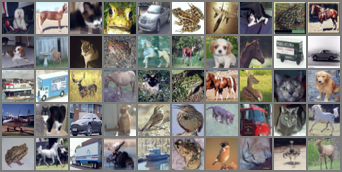

In [ ]:
# Get some random training images
dataiter = iter(check_loader)
images, labels = dataiter.next()

# Create grid of images
img_grid = torchvision.utils.make_grid(images[0:50], nrow = 10)

# Logging to W&B
images = wandb.Image(img_grid, caption = "Sample images")
images.image

## <Font color = 'pickle'>**1. Implement CNN on CIFAR10 Dataset**

In [ ]:
from torch.nn.modules import Conv2d
class Cifar10CNN(nn.Module):
    def __init__(self):
      super().__init__()

      self.conv1_layer = nn.Sequential(
          nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=2, bias=True),
                                    nn.ReLU(),
                                    nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding = 1, bias = True),
                                    nn.ReLU(),

      )

      self.flatten = nn.Flatten()
      self.fc2 = nn.Linear(16*32*32, out_features=10)

    def forward(self,x):
        x = self.conv1_layer(x)
        x = self.flatten(x)
        x = F.relu(self.fc2(x))

        return x
                                   


In [ ]:
from torchsummary import summary
summary(Cifar10CNN().cuda(), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]           2,432
              ReLU-2           [-1, 32, 32, 32]               0
            Conv2d-3           [-1, 16, 32, 32]           4,624
              ReLU-4           [-1, 16, 32, 32]               0
           Flatten-5                [-1, 16384]               0
            Linear-6                   [-1, 10]         163,850
Total params: 170,906
Trainable params: 170,906
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.88
Params size (MB): 0.65
Estimated Total Size (MB): 1.54
----------------------------------------------------------------


### <Font color = 'pickle'>**Function for Training  Loop**

In [ ]:
def train(train_loader, loss_function, model, optimizer, grad_clipping, max_norm, log_batch, log_interval):

  # Training Loop 

  # initilalize variables as global
  # these counts will be updated every epoch
  global batch_ct_train

  # Initialize train_loss at the he start of the epoch
  running_train_loss = 0
  running_train_correct = 0
  
  # put the model in training mode

  model.train()
  # Iterate on batches from the dataset using train_loader
  for input_, targets in train_loader:
    
    # move inputs and outputs to GPUs
    input_ = input_.to(device)
    targets = targets.to(device)


    # Step 1: Forward Pass: Compute model's predictions 
    output = model(input_)
    
    # Step 2: Compute loss
    loss = loss_function(output, targets)

    # Correct prediction
    y_pred = torch.argmax(output, dim = 1)
    correct = torch.sum(y_pred == targets)

    batch_ct_train += 1

    # Step 3: Backward pass -Compute the gradients
    optimizer.zero_grad()
    loss.backward()

    # Gradient Clipping
    if grad_clipping:
      nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_norm, norm_type=2)

    # Step 4: Update the parameters
    optimizer.step()
    
    # For One Cycle Learning Rate - add step here
    # scheduler.step()
          
    # Add train loss of a batch 
    running_train_loss += loss.item()

    # Add Corect counts of a batch
    running_train_correct += correct

    # log batch loss and accuracy
    if log_batch:
      if ((batch_ct_train + 1) % log_interval) == 0:
        wandb.log({f"Train Batch Loss  :": loss})
        wandb.log({f"Train Batch Acc :": correct/len(targets)})
        # print(f'Learning rate: {scheduler.get_last_lr()}')

  
  # Calculate mean train loss for the whole dataset for a particular epoch
  train_loss = running_train_loss/len(train_loader)

  # Calculate accuracy for the whole dataset for a particular epoch
  train_acc = running_train_correct/len(train_loader.dataset)
  

  return train_loss, train_acc

## <Font color = 'pickle'>**Function for Validation Loops**


In [ ]:
def validate(valid_loader, loss_function, model, log_batch, log_interval):

  # initilalize variables as global
  # these counts will be updated every epoch
  global batch_ct_valid

  # Validation/Test loop
  # Initialize valid_loss at the he strat of the epoch
  running_val_loss = 0
  running_val_correct = 0

  # put the model in evaluation mode
  model.eval()

  with torch.no_grad():
    for input_,targets in valid_loader:

      # move inputs and outputs to GPUs
      input_ = input_.to(device)
      targets = targets.to(device)

      # Step 1: Forward Pass: Compute model's predictions 
      output = model(input_)

      # Step 2: Compute loss
      loss = loss_function(output, targets)

      # Correct Predictions
      y_pred = torch.argmax(output, dim = 1)
      correct = torch.sum(y_pred == targets)

      batch_ct_valid += 1

      # Add val loss of a batch 
      running_val_loss += loss.item()

      # Add correct count for each batch
      running_val_correct += correct

      # log batch loss and accuracy
      if log_batch:
        if ((batch_ct_valid + 1) % log_interval) == 0:
          wandb.log({f"Valid Batch Loss  :": loss})
          wandb.log({f"Valid Batch Accuracy :": correct/len(targets)})

    # Calculate mean val loss for the whole dataset for a particular epoch
    val_loss = running_val_loss/len(valid_loader)

    # Calculate accuracy for the whole dataset for a particular epoch
    val_acc = running_val_correct/len(valid_loader.dataset)

    # scheduler step
    # scheduler.step(val_loss)
    # scheduler.step()
    
  return val_loss, val_acc

## <Font color = 'pickle'>**Function for Model Training**

In [ ]:
def train_loop(train_loader, valid_loader, model, optimizer, loss_function, epochs, device, patience, early_stopping,
               file_model, save_best_model):
    
  """ 
  Function for training the model and plotting the graph for train & validation loss vs epoch.
  Input: iterator for train dataset, initial weights and bias, epochs, learning rate, batch size.
  Output: final weights, bias and train loss and validation loss for each epoch.
  """

  # Create lists to store train and val loss at each epoch
  train_loss_history = []
  valid_loss_history = []
  train_acc_history = []
  valid_acc_history = []

  # initialize variables for early stopping

  delta = 0
  best_score = None
  valid_loss_min = np.Inf
  counter_early_stop=0
  early_stop=False

  # Iterate for the given number of epochs
  # Step 5: Repeat steps 1 - 4

  for epoch in range(epochs):

    t0 = datetime.now()

    # Get train loss and accuracy for one epoch
    train_loss, train_acc = train(train_loader, loss_function, model, optimizer, 
                                  wandb.config.grad_clipping, wandb.config.max_norm,
                                  wandb.config.log_batch, wandb.config.log_interval)
    valid_loss, valid_acc   = validate(valid_loader, loss_function, model, wandb.config.log_batch, wandb.config.log_interval)

    dt = datetime.now() - t0

    # Save history of the Losses and accuracy
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)

    valid_loss_history.append(valid_loss)
    valid_acc_history.append(valid_acc)

    # Log the train and valid loss to wandb
    wandb.log({f"Train Loss :": train_loss, "epoch": epoch})
    wandb.log({f"Train Acc :": train_acc, "epoch": epoch})

    wandb.log({f"Valid Loss :": valid_loss, "epoch": epoch})
    wandb.log({f"Valid Acc :": valid_acc, "epoch": epoch})

    if early_stopping:
      score = -valid_loss
      if best_score is None:
        best_score=score
        print(f'Validation loss has decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}). Saving Model...')
        torch.save(model.state_dict(), file_model)
        valid_loss_min = valid_loss

      elif score < best_score + delta:
        counter_early_stop += 1
        print(f'Early stoping counter: {counter_early_stop} out of {patience}')
        if counter_early_stop > patience:
          early_stop = True

      
      else:
        best_score = score
        print(f'Validation loss has decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}). Saving model...')
        torch.save(model.state_dict(), file_model)
        counter_early_stop=0
        valid_loss_min = valid_loss

      if early_stop:
        print('Early Stopping')
        break

    elif save_best_model:

      score = -valid_loss
      if best_score is None:
        best_score=score
        print(f'Validation loss has decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}). Saving Model...')
        torch.save(model.state_dict(), file_model)
        valid_loss_min = valid_loss

      elif score < best_score + delta:
        print(f'Validation loss has not decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}). Not Saving Model...')
      
      else:
        best_score = score
        print(f'Validation loss has decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}). Saving model...')
        torch.save(model.state_dict(), file_model)
        valid_loss_min = valid_loss
        
    else:
        torch.save(model.state_dict(), file_model)
    
    # Print the train loss and accuracy for given number of epochs, batch size and number of samples
    print(f'Epoch : {epoch+1} / {epochs}')
    print(f'Time to complete {epoch+1} is {dt}')
    # print(f'Learning rate: {scheduler._last_lr[0]}') # for ReduceLR
    # print(f'Learning rate: {scheduler.get_last_lr()}') # for OneCycle
    print(f'Train Loss: {train_loss : .4f} | Train Accuracy: {train_acc * 100 : .4f}%')
    print(f'Valid Loss: {valid_loss : .4f} | Valid Accuracy: {valid_acc * 100 : .4f}%')
    print()
    torch.cuda.empty_cache()

  return train_loss_history, train_acc_history, valid_loss_history, valid_acc_history

## <Font color = 'pickle'>**Function for Accuracy and Predictions**

In [ ]:
def get_acc_pred(data_loader, model, device):
    
  """ 
  Function to get predictions and accuracy for a given data using estimated model
  Input: Data iterator, Final estimated weoights, bias
  Output: Prections and Accuracy for given dataset
  """

  # Array to store predicted labels
  predictions = torch.Tensor() # empty tensor
  predictions = predictions.to(device) # move predictions to GPU

  # Array to store actual labels
  y = torch.Tensor() # empty tensor
  y = y.to(device)

  # put the model in evaluation mode
  model.eval()
  
  # Iterate over batches from data iterator
  with torch.no_grad():
    for input_, targets in data_loader:
      
      # move inputs and outputs to GPUs
      
      input_ = input_.to(device)
      targets = targets.to(device)
      
      # Calculated the predicted labels
      output = model(input_)

      # Choose the label with maximum probability
      prediction = torch.argmax(output, dim = 1)

      # Add the predicted labels to the array
      predictions = torch.cat((predictions, prediction)) 

      # Add the actual labels to the array
      y = torch.cat((y, targets)) 

  # Check for complete dataset if actual and predicted labels are same or not
  # Calculate accuracy
  acc = (predictions == y).float().mean()

  # Return tuple containing predictions and accuracy
  return predictions, acc  

# <Font color = 'pickle'>**Meta Data**

In [ ]:
hyperparameters = SimpleNamespace(
    epochs = 20,
    output_dim = 10,
    batch_size=256,
    learning_rate=1e-2,
    dataset="Cifar10",
    architecture="Cifar10_CustomNN",
    log_interval = 100,
    log_batch = True,
    file_model = model_folder/'cifar10_custom_model.pt',
    grad_clipping = True,
    max_norm = 1,
    momentum = 0.9,
    patience = 5,
    early_stopping = True,
    scheduler_factor = 0.5,
    scheduler_patience = 0,
    save_best_model = False,
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu'),
    weight_decay = 0,
    
    
    )

# <Font color = 'pickle'>**Data Loaders, Loss Function, Optimizer**

In [ ]:
wandb.config = hyperparameters
wandb.config

namespace(architecture='Cifar10_CustomNN', batch_size=256, dataset='Cifar10', device=device(type='cuda', index=0), early_stopping=True, epochs=20, file_model=PosixPath('/content/drive/MyDrive/Deep_Learning_UTD/Model/cifar10_custom_model.pt'), grad_clipping=True, learning_rate=0.01, log_batch=True, log_interval=100, max_norm=1, momentum=0.9, output_dim=10, patience=5, save_best_model=False, scheduler_factor=0.5, scheduler_patience=0, weight_decay=0)

In [ ]:
# Fix seed value
SEED = 2345
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Data Loader
train_loader = torch.utils.data.DataLoader(trainset, batch_size=wandb.config.batch_size, shuffle = True)
valid_loader = torch.utils.data.DataLoader(validset, batch_size=wandb.config.batch_size, shuffle = False)
test_loader = torch.utils.data.DataLoader(testset, batch_size=wandb.config.batch_size,   shuffle = False)

# model 
model = Cifar10CNN()

# Initialize weights from normal distribution with mean 0 and standard deviation 0.01
def init_weights(m):
  if type(m) == nn.Linear:
        torch.nn.init.kaiming_normal_(m.weight)
        torch.nn.init.zeros_(m.bias)

  if type(m) == nn.Conv2d:
        torch.nn.init.kaiming_normal_(m.weight)
        torch.nn.init.zeros_(m.bias)

model.to(wandb.config.device)
# model.apply(init_weights)

# loss_function
loss_function = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), 
                            lr = wandb.config.learning_rate, 
                            momentum = wandb.config.momentum,
                            weight_decay = wandb.config.weight_decay)

# scheduler = ReduceLROnPlateau(optimizer, mode='min', factor= wandb.config.scheduler_factor, 
#                               patience=wandb.config.scheduler_patience, verbose=True)



# <Font color = 'pickle'>**Training Model**

In [ ]:
wandb.watch(model, log = 'all', log_freq=25, log_graph=True)

wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
# See live graphs in the notebook.
#%%wandb 
batch_ct_train, batch_ct_valid = 0, 0
train_loss_history, train_acc_history, valid_loss_history, valid_acc_history = train_loop(train_loader, 
                                                                                          valid_loader, 
                                                                                          model, 
                                                                                          optimizer, 
                                                                                          loss_function, 
                                                                                          wandb.config.epochs, 
                                                                                          wandb.config.device,
                                                                                          wandb.config.patience,
                                                                                          wandb.config.early_stopping,
                                                                                          wandb.config.file_model,
                                                                                          wandb.config.save_best_model
                                                                                          )

Validation loss has decreased (inf --> 1.951506). Saving Model...
Epoch : 1 / 20
Time to complete 1 is 0:00:13.998869
Train Loss:  2.0739 | Train Accuracy:  29.4625%
Valid Loss:  1.9515 | Valid Accuracy:  34.0700%

Validation loss has decreased (1.951506 --> 1.702215). Saving model...
Epoch : 2 / 20
Time to complete 2 is 0:00:13.409972
Train Loss:  1.7974 | Train Accuracy:  39.9425%
Valid Loss:  1.7022 | Valid Accuracy:  42.1400%

Validation loss has decreased (1.702215 --> 1.645574). Saving model...
Epoch : 3 / 20
Time to complete 3 is 0:00:13.344534
Train Loss:  1.6065 | Train Accuracy:  45.0850%
Valid Loss:  1.6456 | Valid Accuracy:  43.4800%

Validation loss has decreased (1.645574 --> 1.612931). Saving model...
Epoch : 4 / 20
Time to complete 4 is 0:00:13.294269
Train Loss:  1.5368 | Train Accuracy:  47.4725%
Valid Loss:  1.6129 | Valid Accuracy:  44.1600%

Validation loss has decreased (1.612931 --> 1.566517). Saving model...
Epoch : 5 / 20
Time to complete 5 is 0:00:13.259495
Tr

## <Font color = 'pickle'>**2. Experiment different CNN on CIFAR10 Dataset**

In [ ]:
#Subset of 50 images

# n sample points
train_sample_size = 50

# Getting n random indices
train_subset_indices = random.sample(range(0, len(trainset)), train_sample_size)

# Getting subset of dataset
train_subset = torch.utils.data.Subset(trainset, train_subset_indices)

train_subset.dataset.dataset.data[train_subset.indices].shape

(50, 32, 32, 3)

## Experiment 1 - Denser Network and Wider Network

Conv ( Kernel Size = 10 )->ReLU->MaxPool ( Kernel Size = 2, Stride = 2 ) <br>
Conv ( Kernel Size = 5 )->ReLU->BatchNorm <br>
Conv ( Kernel Size = 3 )->ReLU->MaxPool (Kernel Size = 2, Stride = 2 ) <br>

<br>

Flatten-> Linear_Layer

Optimizer = SGD

<br>
LR Scheduler - ReduceLROnPlateau




## Experiment 2 - Denser Network and Wider Network

Conv ( Kernel Size = 12 )->ELU->AvgPool ( Kernel Size = 2, Stride = 2 )<br>
Conv ( Kernel Size = 5 )->ELU->BatchNorm <br>
Conv (Kernel Size = 3 )->ELU->AvgPool (Kernel Size = 2, Stride = 2) <br>

<br>

Flatten-> Dropout_Layer-> Linear_Layer
<br> 

Optimizer = SGD

<br>

LR Scheduler - OneCycleLR




## Experiment 3 - Denser Network and Wider Network

Conv ( Kernel Size = 12 )->ReLU->MaxPool (Kernel Size = 2, Stride = 2)<br>
Conv ( Kernel Size = 3 )->ReLU->BatchNorm <br>
Conv (Kernel Size = 2 )->ReLU->MaxPool (Kernel Size = 2, Stride = 2) <br>

<br>

Flatten-> Linear_Layer
<br> 

Optimizer = Adam

<br>

LR Scheduler - ReduceLROnPlateau




## Experiment 4 - Denser Network and Wider Network

Conv ( Kernel Size = 10 ) ->ReLU->MaxPool  (Kernel Size = 2 , stride = 2)<br>
Conv ( Kernel Size = 5 ) ->ReLU->BatchNorm  <br>
Conv (Kernel Size = 3 ) ->ReLU->MaxPool  (Kernel Size = 2 , stride = 2)<br>

<br>

Flatten-> Linear_Layer
<br> 

Optimizer = Adam

<br>

LR Scheduler - ReduceLROnPlateau




## Experiment 5 - Denser Network and Wider Network

Conv (Kernel Size = 10) -> ReLU->AvgPool ( Kernel Size = 2, Stride = 2 )<br>
Conv (Kernel Size = 5) -> ReLU->BatchNorm <br>
Conv (Kernel Size = 3) -> ReLU->AvgPool (Kernel Size = 2, Stride = 2) <br>

<br>

Flatten-> Linear_Layer
<br> 

Optimizer = Adam

<br>

LR Scheduler - ReduceLROnPlateau




## <Font color = 'pickle'>**Best Model**

**Conv ( Kernel Size = 10 )->ReLU->MaxPool ( Kernel Size = 2, Stride = 2 )**<br>
**Conv ( Kernel Size = 5 )->ReLU->BatchNorm
<br>
Conv ( Kernel Size = 3 )->ReLU->MaxPool (Kernel Size = 2, Stride = 2 )** <br>

<br>

**Flatten-> Linear_Layer**
<br> 

**Optimizer = SGD**

LR Scheduler - ReduceLROnPlateau
<br>






In [ ]:
from torch.nn.modules import Conv2d
class Cifar10CNN_Experiment(nn.Module):
    def __init__(self):
      super().__init__()

      self.conv1_layer = nn.Sequential(
          nn.Conv2d(in_channels=3, out_channels=64, kernel_size=10, padding=2, bias=True),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size = 2, stride = 2),
          nn.Conv2d(in_channels=64, out_channels=256, kernel_size=5, padding=2, bias=True),
          nn.ReLU(),
          nn.BatchNorm2d(256,momentum=0.9),
          nn.Conv2d(in_channels=256, out_channels=16, kernel_size=3, padding=2, bias=True),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size = 2, stride = 2)
      )

      self.flatten = nn.Flatten()
      self.fc2 = nn.Linear(16*7*7, out_features=10)

    def forward(self,x):
        x = self.conv1_layer(x)
        x = self.flatten(x)
        x = F.relu(self.fc2(x))

        return x
                                   


In [ ]:
from torchsummary import summary
summary(Cifar10CNN_Experiment().cuda(), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 27, 27]          19,264
              ReLU-2           [-1, 64, 27, 27]               0
         MaxPool2d-3           [-1, 64, 13, 13]               0
            Conv2d-4          [-1, 256, 13, 13]         409,856
              ReLU-5          [-1, 256, 13, 13]               0
       BatchNorm2d-6          [-1, 256, 13, 13]             512
            Conv2d-7           [-1, 16, 15, 15]          36,880
              ReLU-8           [-1, 16, 15, 15]               0
         MaxPool2d-9             [-1, 16, 7, 7]               0
          Flatten-10                  [-1, 784]               0
           Linear-11                   [-1, 10]           7,850
Total params: 474,362
Trainable params: 474,362
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/

### <Font color = 'pickle'>**Function for Training  Loop**

In [ ]:
def train(train_loader, loss_function, model, optimizer, grad_clipping, max_norm, log_batch, log_interval):

  # Training Loop 

  # initilalize variables as global
  # these counts will be updated every epoch
  global batch_ct_train

  # Initialize train_loss at the he start of the epoch
  running_train_loss = 0
  running_train_correct = 0
  
  # put the model in training mode

  model.train()
  # Iterate on batches from the dataset using train_loader
  for input_, targets in train_loader:
    
    # move inputs and outputs to GPUs
    input_ = input_.to(device)
    targets = targets.to(device)


    # Step 1: Forward Pass: Compute model's predictions 
    output = model(input_)
    
    # Step 2: Compute loss
    loss = loss_function(output, targets)

    # Correct prediction
    y_pred = torch.argmax(output, dim = 1)
    correct = torch.sum(y_pred == targets)

    batch_ct_train += 1

    # Step 3: Backward pass -Compute the gradients
    optimizer.zero_grad()
    loss.backward()

    # Gradient Clipping
    if grad_clipping:
      nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_norm, norm_type=2)

    # Step 4: Update the parameters
    optimizer.step()
    
    # For One Cycle Learning Rate - add step here
    # scheduler.step()
          
    # Add train loss of a batch 
    running_train_loss += loss.item()

    # Add Corect counts of a batch
    running_train_correct += correct

    # log batch loss and accuracy
    if log_batch:
      if ((batch_ct_train + 1) % log_interval) == 0:
        wandb.log({f"Train Batch Loss  :": loss})
        wandb.log({f"Train Batch Acc :": correct/len(targets)})
        # print(f'Learning rate: {scheduler.get_last_lr()}')

  
  # Calculate mean train loss for the whole dataset for a particular epoch
  train_loss = running_train_loss/len(train_loader)

  # Calculate accuracy for the whole dataset for a particular epoch
  train_acc = running_train_correct/len(train_loader.dataset)
  

  return train_loss, train_acc

## <Font color = 'pickle'>**Function for Validation Loops**


In [ ]:
def validate(valid_loader, loss_function, model, log_batch, log_interval):

  # initilalize variables as global
  # these counts will be updated every epoch
  global batch_ct_valid

  # Validation/Test loop
  # Initialize valid_loss at the he strat of the epoch
  running_val_loss = 0
  running_val_correct = 0

  # put the model in evaluation mode
  model.eval()

  with torch.no_grad():
    for input_,targets in valid_loader:

      # move inputs and outputs to GPUs
      input_ = input_.to(device)
      targets = targets.to(device)

      # Step 1: Forward Pass: Compute model's predictions 
      output = model(input_)

      # Step 2: Compute loss
      loss = loss_function(output, targets)

      # Correct Predictions
      y_pred = torch.argmax(output, dim = 1)
      correct = torch.sum(y_pred == targets)

      batch_ct_valid += 1

      # Add val loss of a batch 
      running_val_loss += loss.item()

      # Add correct count for each batch
      running_val_correct += correct

      # log batch loss and accuracy
      if log_batch:
        if ((batch_ct_valid + 1) % log_interval) == 0:
          wandb.log({f"Valid Batch Loss  :": loss})
          wandb.log({f"Valid Batch Accuracy :": correct/len(targets)})

    # Calculate mean val loss for the whole dataset for a particular epoch
    val_loss = running_val_loss/len(valid_loader)

    # Calculate accuracy for the whole dataset for a particular epoch
    val_acc = running_val_correct/len(valid_loader.dataset)

    # scheduler step
    scheduler.step(val_loss)
    
  return val_loss, val_acc

## <Font color = 'pickle'>**Function for Model Training**

In [ ]:
def train_loop(train_loader, valid_loader, model, optimizer, loss_function, epochs, device, patience, early_stopping,
               file_model, save_best_model):
    
  """ 
  Function for training the model and plotting the graph for train & validation loss vs epoch.
  Input: iterator for train dataset, initial weights and bias, epochs, learning rate, batch size.
  Output: final weights, bias and train loss and validation loss for each epoch.
  """

  # Create lists to store train and val loss at each epoch
  train_loss_history = []
  valid_loss_history = []
  train_acc_history = []
  valid_acc_history = []

  # initialize variables for early stopping

  delta = 0
  best_score = None
  valid_loss_min = np.Inf
  counter_early_stop=0
  early_stop=False

  # Iterate for the given number of epochs
  # Step 5: Repeat steps 1 - 4

  for epoch in range(epochs):

    t0 = datetime.now()

    # Get train loss and accuracy for one epoch
    train_loss, train_acc = train(train_loader, loss_function, model, optimizer, 
                                  wandb.config.grad_clipping, wandb.config.max_norm,
                                  wandb.config.log_batch, wandb.config.log_interval)
    valid_loss, valid_acc   = validate(valid_loader, loss_function, model, wandb.config.log_batch, wandb.config.log_interval)

    dt = datetime.now() - t0

    # Save history of the Losses and accuracy
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)

    valid_loss_history.append(valid_loss)
    valid_acc_history.append(valid_acc)

    # Log the train and valid loss to wandb
    wandb.log({f"Train Loss :": train_loss, "epoch": epoch})
    wandb.log({f"Train Acc :": train_acc, "epoch": epoch})

    wandb.log({f"Valid Loss :": valid_loss, "epoch": epoch})
    wandb.log({f"Valid Acc :": valid_acc, "epoch": epoch})

    if early_stopping:
      score = -valid_loss
      if best_score is None:
        best_score=score
        print(f'Validation loss has decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}). Saving Model...')
        torch.save(model.state_dict(), file_model)
        valid_loss_min = valid_loss

      elif score < best_score + delta:
        counter_early_stop += 1
        print(f'Early stoping counter: {counter_early_stop} out of {patience}')
        if counter_early_stop > patience:
          early_stop = True

      
      else:
        best_score = score
        print(f'Validation loss has decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}). Saving model...')
        torch.save(model.state_dict(), file_model)
        counter_early_stop=0
        valid_loss_min = valid_loss

      if early_stop:
        print('Early Stopping')
        break

    elif save_best_model:

      score = -valid_loss
      if best_score is None:
        best_score=score
        print(f'Validation loss has decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}). Saving Model...')
        torch.save(model.state_dict(), file_model)
        valid_loss_min = valid_loss

      elif score < best_score + delta:
        print(f'Validation loss has not decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}). Not Saving Model...')
      
      else:
        best_score = score
        print(f'Validation loss has decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}). Saving model...')
        torch.save(model.state_dict(), file_model)
        valid_loss_min = valid_loss
        
    else:
        torch.save(model.state_dict(), file_model)
    
    # Print the train loss and accuracy for given number of epochs, batch size and number of samples
    print(f'Epoch : {epoch+1} / {epochs}')
    print(f'Time to complete {epoch+1} is {dt}')
    print(f'Learning rate: {scheduler._last_lr[0]}') # for ReduceLR
    # print(f'Learning rate: {scheduler.get_last_lr()}') # for OneCycle
    print(f'Train Loss: {train_loss : .4f} | Train Accuracy: {train_acc * 100 : .4f}%')
    print(f'Valid Loss: {valid_loss : .4f} | Valid Accuracy: {valid_acc * 100 : .4f}%')
    print()
    torch.cuda.empty_cache()

  return train_loss_history, train_acc_history, valid_loss_history, valid_acc_history

## <Font color = 'pickle'>**Function for Accuracy and Predictions**

In [ ]:
def get_acc_pred(data_loader, model, device):
    
  """ 
  Function to get predictions and accuracy for a given data using estimated model
  Input: Data iterator, Final estimated weoights, bias
  Output: Prections and Accuracy for given dataset
  """

  # Array to store predicted labels
  predictions = torch.Tensor() # empty tensor
  predictions = predictions.to(device) # move predictions to GPU

  # Array to store actual labels
  y = torch.Tensor() # empty tensor
  y = y.to(device)

  # put the model in evaluation mode
  model.eval()
  
  # Iterate over batches from data iterator
  with torch.no_grad():
    for input_, targets in data_loader:
      
      # move inputs and outputs to GPUs
      
      input_ = input_.to(device)
      targets = targets.to(device)
      
      # Calculated the predicted labels
      output = model(input_)

      # Choose the label with maximum probability
      prediction = torch.argmax(output, dim = 1)

      # Add the predicted labels to the array
      predictions = torch.cat((predictions, prediction)) 

      # Add the actual labels to the array
      y = torch.cat((y, targets)) 

  # Check for complete dataset if actual and predicted labels are same or not
  # Calculate accuracy
  acc = (predictions == y).float().mean()

  # Return tuple containing predictions and accuracy
  return predictions, acc  

# <Font color = 'pickle'>**Meta Data**

In [ ]:
hyperparameters2 = SimpleNamespace(
    epochs = 10,
    output_dim = 10,
    batch_size=256,
    learning_rate=1e-2,
    dataset="Cifar10",
    architecture="Cifar10_CustomNN_Experiment",
    log_interval = 100,
    log_batch = True,
    file_model = model_folder/'cifar10_custom_model_experiment.pt',
    grad_clipping = True,
    max_norm = 1,
    momentum = 0.9,
    patience = 5,
    early_stopping = False,
    scheduler_factor = 0.5,
    scheduler_patience = 0,
    save_best_model = False,
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu'),
    weight_decay = 0,
    
    
    )

In [ ]:
# Initialize a new project
wandb.init(name = "Best_Model", project = 'dl22_HW6' , config = hyperparameters2)

# <Font color = 'pickle'>**Data Loaders, Loss Function, Optimizer**

In [ ]:
wandb.config = hyperparameters2
wandb.config

namespace(architecture='Cifar10_CustomNN_Experiment', batch_size=256, dataset='Cifar10', device=device(type='cuda', index=0), early_stopping=False, epochs=10, file_model=PosixPath('/content/drive/MyDrive/Deep_Learning_UTD/Model/cifar10_custom_model_experiment.pt'), grad_clipping=True, learning_rate=0.01, log_batch=True, log_interval=100, max_norm=1, momentum=0.9, output_dim=10, patience=5, save_best_model=False, scheduler_factor=0.5, scheduler_patience=0, weight_decay=0)

In [ ]:
# Fix seed value
SEED = 2345
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Data Loader
train_loader = torch.utils.data.DataLoader(trainset, batch_size=wandb.config.batch_size, shuffle = True)
valid_loader = torch.utils.data.DataLoader(validset, batch_size=wandb.config.batch_size, shuffle = False)
test_loader = torch.utils.data.DataLoader(testset, batch_size=wandb.config.batch_size,   shuffle = False)

# model 
model = Cifar10CNN_Experiment()

# Initialize weights from normal distribution with mean 0 and standard deviation 0.01
def init_weights(m):
  if type(m) == nn.Linear:
        torch.nn.init.kaiming_normal_(m.weight)
        torch.nn.init.zeros_(m.bias)

  if type(m) == nn.Conv2d:
        torch.nn.init.kaiming_normal_(m.weight)
        torch.nn.init.zeros_(m.bias)

model.to(wandb.config.device)
# model.apply(init_weights)

# loss_function
loss_function = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), 
                            lr = wandb.config.learning_rate, 
                            momentum = wandb.config.momentum,
                            weight_decay = wandb.config.weight_decay)

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor= wandb.config.scheduler_factor, 
                              patience=wandb.config.scheduler_patience, verbose=True)



# <Font color = 'pickle'>**Training Model**

In [ ]:
wandb.watch(model, log = 'all', log_freq=25, log_graph=True)

wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
# See live graphs in the notebook.
#%%wandb 
batch_ct_train, batch_ct_valid = 0, 0
train_loss_history, train_acc_history, valid_loss_history, valid_acc_history = train_loop(train_loader, 
                                                                                          valid_loader, 
                                                                                          model, 
                                                                                          optimizer, 
                                                                                          loss_function, 
                                                                                          wandb.config.epochs, 
                                                                                          wandb.config.device,
                                                                                          wandb.config.patience,
                                                                                          wandb.config.early_stopping,
                                                                                          wandb.config.file_model,
                                                                                          wandb.config.save_best_model
                                                                                          )

Epoch : 1 / 10
Time to complete 1 is 0:00:16.345803
Learning rate: 0.01
Train Loss:  1.7244 | Train Accuracy:  39.0825%
Valid Loss:  1.4698 | Valid Accuracy:  48.9900%

Epoch : 2 / 10
Time to complete 2 is 0:00:16.486050
Learning rate: 0.01
Train Loss:  1.2539 | Train Accuracy:  55.7850%
Valid Loss:  1.1999 | Valid Accuracy:  57.5600%

Epoch : 3 / 10
Time to complete 3 is 0:00:19.379684
Learning rate: 0.01
Train Loss:  1.0662 | Train Accuracy:  62.5175%
Valid Loss:  1.0884 | Valid Accuracy:  61.8200%

Epoch : 4 / 10
Time to complete 4 is 0:00:16.196145
Learning rate: 0.01
Train Loss:  0.9564 | Train Accuracy:  66.7375%
Valid Loss:  1.0169 | Valid Accuracy:  64.2400%

Epoch : 5 / 10
Time to complete 5 is 0:00:17.563714
Learning rate: 0.01
Train Loss:  0.8727 | Train Accuracy:  69.6100%
Valid Loss:  1.0085 | Valid Accuracy:  64.4600%

Epoch : 6 / 10
Time to complete 6 is 0:00:16.294586
Learning rate: 0.01
Train Loss:  0.8015 | Train Accuracy:  72.1725%
Valid Loss:  0.9290 | Valid Accurac

## Wandb Link

WANDB Link - https://wandb.ai/pranavshekhar2/dl22_HW6?workspace=user-pranavshekhar2